In [1]:
import sys
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text

import warnings
warnings.filterwarnings("ignore")

2022-09-12 16:08:41.618415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 16:08:42.159113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 16:08:42.159144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-12 16:08:42.243065: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-12 16:08:43.506548: W tensorflow/stream_executor/platform/de

# 1. Carga de Datos y AED

In [2]:
text = pd.read_csv("SMSSpamCollection(Filtrada).csv", on_bad_lines='skip', sep=';')
text.shape

(1290, 2)

In [4]:
text.head()

,resultado,mensaje
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,ham,As per your request 'Melle Melle (Oru Minnamin...
3,spam,WINNER!! As a valued network customer you have...
4,spam,Had your mobile 11 months or more? U R entitle...


<AxesSubplot:ylabel='resultado'>

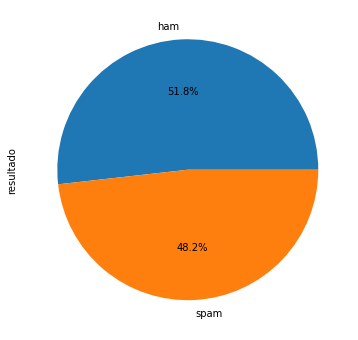

In [4]:
ratio_spam_and_ham = text["resultado"].value_counts()
ratio_spam_and_ham.plot.pie(autopct = '%1.1f%%', fontsize=10, figsize=(6,6))

In [5]:
def visualize(label, data):
    words=''
    for msg in data[data['resultado'] == label]['mensaje']:
        msg = msg.lower()
        words+=msg + ''
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("SPAM msj:")
#visualize('spam', text)

print("HAM msj:")
#visualize('ham', text)

SPAM msj:
HAM msj:


# 2. Preprocesamiento de Texto

## 2.1. Expresiones Regulares

In [3]:
# Use regular expression

def regular_expression(processed) :
    # Replace email addresses with 'email'
    processed = processed.str.replace(r'^.+@[^\.].*\.[a-z]', 'emailaddress', regex=True)

    # Replace URLs with 'webaddress'
    processed = processed.str.replace(r'https?://[A-Za-z0-9./]+', 'webaddress', regex=True)

    # Replace URLs with 'webaddress'
    processed = processed.str.replace(r'www.[A-Za-z0-9./]+', 'webaddress', regex=True)

    # Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
    processed = processed.str.replace(r'£|\$', 'moneysymb', regex=True)

    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', regex=True)

    # Replace numbers with 'numbr'
    processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)
    
    # Remove punctuation
    processed = processed.str.replace(r'[^\w\d\s]', ' ', regex=True)

    # Replace whitespace between terms with a single space
    processed = processed.str.replace(r'\s+', ' ', regex=True)

    # Remove leading and trailing whitespace
    processed = processed.str.replace(r'^\s+|\s+?$', '', regex=True)
    
    return processed

In [4]:
# Apply lowercase

def lowercase(processed) :
    processed = processed.str.lower()
    return processed

## 2.2. Stop Words

In [5]:
# Remove Stop Words

def stop_words(processed) :
    stop_words = set(stopwords.words('english'))
    processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
    return processed

## 2.3. Stemming and Lemmatization

Stemming identifies the common root form of a word by removing or replacing word suffixes (e.g. “flooding” is stemmed as “flood”), while lemmatization identifies the inflected forms of a word and returns its base form (e.g. “better” is lemmatized as “good”).

Huang, X., Li, Z., Wang, C., & Ning, H. (2020). Identifying disaster related social media for rapid response: a visual-textual fused CNN architecture. International Journal of Digital Earth, 13(9), 1017–1039. https://doi.org/10.1080/17538947.2019.1633425

In [6]:
# Apply ONLY Stemming

def stemming(processed) :
    snow = nltk.SnowballStemmer(language='english')
    processed = processed.apply(lambda x: ' '.join(snow.stem(term) for term in x.split()))
    return processed

In [7]:
# Apply ONLY Lemmatization

def lemmatization(processed) :
    lmt = nltk.stem.WordNetLemmatizer()
    processed = processed.apply(lambda x: ' '.join(lmt.lemmatize(term) for term in x.split()))
    return processed

## 2.4. Aplicar preprocesamientos

In [8]:
def preprocessing(processed) :
    processed = regular_expression(processed)
    processed = lowercase(processed)
    processed = stop_words(processed)
    # processed = stemming(processed)
    processed = lemmatization(processed)
    return processed

In [9]:
processed = preprocessing(text["mensaje"])

# 3. Definir Modelo de Clasificación

## 3.1. Machine Learning

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

import time

In [11]:
def confusion_matrix(clf_best, X_test, y_test) :
    disp = ConfusionMatrixDisplay.from_estimator(
       clf_best,
       X_test,
       y_test,
       display_labels=None,
       cmap=plt.cm.Blues,
       normalize=None)

    disp.ax_.set_xlabel('Predicción');
    disp.ax_.set_ylabel('Realidad'); 
    disp.ax_.xaxis.set_ticklabels(['0', '1']); 
    disp.ax_.yaxis.set_ticklabels(['0', '1']);
    
    print(disp.confusion_matrix)

    plt.show()

In [29]:
from sklearn.metrics import precision_score, make_scorer

def classifier(clf, parameters, X_train, y_train, X_test, y_test) :
    #### Train
    print('=> Train')
    print(' ')
    # Start stopwatch
    tic = time.time() 
    precision_scorer = make_scorer(precision_score, zero_division=1)
    custom_scoring = {"precision": precision_scorer, "f1": "f1"}
    clf = GridSearchCV(clf, parameters, scoring = custom_scoring, refit='f1', n_jobs = -1)
    #clf = GridSearchCV(clf, parameters, scoring = 'f1', n_jobs = -1)
    clf.fit(X_train, y_train)
    print('Best estimator: ', clf.best_estimator_)
    print(' ')
    #print('Best estimator: ', clf.best_score_)
    print('Best mean validation f1 score: ', clf.cv_results_['mean_test_precision'][clf.best_index_])
    print('Best std validation f1 score: ', clf.cv_results_['std_test_precision'][clf.best_index_])
    print(' ')
    print('Best mean validation precision score: ', clf.cv_results_['mean_test_f1'][clf.best_index_])
    print('Best std validation precision score: ', clf.cv_results_['std_test_f1'][clf.best_index_])
    # End stopwatch train
    toc_train = time.time() 
    print(' ')
    print("time to train process : " + str(round(toc_train - tic, 2)) + " sec" )
    
    #### Test
    print(' ')
    print('=> Test')
    clf_best = clf.best_estimator_
    pred = clf_best.predict(X_test)
    print(' ')
    print('1) Report:')
    print(' ')
    print(classification_report(y_test, pred, zero_division=1))
    print(' ')
    print('2) Confussion Matrix')
    print(' ')
    y_pred = clf_best.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(' ')
    # End stopwatch train
    toc_test = time.time() 
    print("time to test process : " + str(round(toc_test - toc_train, 2)) + " sec" )
    print(' ')
    # End stopwatch
    toc_test = time.time() 
    print("==== time to total process! : " + str(round(toc_test - tic, 2)) + " sec ====" )

### 3.1.1. Hiperparámetros SVC

In [27]:
from sklearn.svm import SVC
# Hiperparameters
parameters_svc = {
    'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'kernel': ['rbf', 'linear','sigmoid']
}
# Base model
svc = SVC(random_state=42)

### 3.1.2. Hiperparámetros NuSVC

In [14]:
from sklearn.svm import NuSVC
# Hiperparameters
parameters_nusvc = {
    'nu' : [0.001, 0.01, 0.1, 0.9],
    'gamma': np.logspace(-9, 3, 8), 
    'kernel': ['rbf', 'linear', 'sigmoid']
}
# Base model
nusvc = NuSVC(random_state=42)

## 3.2. Deep Learning

In [15]:
import tensorflow as tf
from tensorflow import keras 
import tensorflow_addons as tfa
    
def deeplearning(X_train, y_train, X_test, y_test, lr, epochs) :
    n = X_train.shape[1]
    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    # Start stopwatch
    tic = time.time() 
    model = keras.models.Sequential([
        keras.layers.Input(shape = (n,), sparse=True),
        keras.layers.Dense(300, activation = 'relu'),
        keras.layers.Dense(100, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.summary()
    model.compile(optimizer=keras.optimizers.SGD(lr=lr),
                  loss='binary_crossentropy',
                  #metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
                  metrics=[tf.keras.metrics.Precision(), tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
    history = model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, batch_size = 32, verbose = 0)
    # End stopwatch train
    toc_train = time.time() 
    print(' ')
    print("time to train process : " + str(round(toc_train - tic, 2)) + " sec" )
    
    # Test
    loss, precision, f1 = model.evaluate(X_test, y_test, steps=5, verbose=2)
    print(' ')
    print('Scores:')
    print('- Precision score:', precision)
    print('- F1 score:', f1[0])
    print(' ')
    # Curva de Aprendizaje
    print('Curva de Aprendizaje')
    pd.DataFrame(history.history).astype(float).plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 1)
    plt.show()
    print(' ')
    y_pred = (model.predict(X_test).ravel()>0.5)+0
    print('2) Confussion Matrix')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # End stopwatch train
    toc_test = time.time() 
    print("time to test process : " + str(round(toc_test - toc_train, 2)) + " sec" )
    print(' ')
    # End stopwatch
    toc_test = time.time() 
    print("==== time to total process! : " + str(round(toc_test - tic, 2)) + " sec ====" )
    
    return history

# 4. Definir Métodos de Embedding

## 4.1. Embeding Tradicional

### 4.1.1. TF-IDF

In [16]:
# TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(corpus) :
    # Start stopwatch
    tic = time.time()
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus).toarray()
    
    # End stopwatch 
    toc = time.time() 
    print("time to embedding process  : " + str(round(toc - tic, 2)) + " sec" )

    return X

### 4.1.2. Hashing Vectorizer

In [17]:
# TfidfVectorizer

from sklearn.feature_extraction.text import HashingVectorizer

def hashingvectorizer(corpus) :
    # Start stopwatch
    tic = time.time()
    
    vectorizer = HashingVectorizer(n_features = 4096)
    X = vectorizer.fit_transform(corpus).toarray()
    
    # End stopwatch 
    toc = time.time() 
    print("time to embedding process  : " + str(round(toc - tic, 2)) + " sec" )

    return X

## 4.2. Método BERT

Existen varios subgrupos pertenecientes a la familia de modelos BERT, entre ellos:

- BERT Base : modelos con diferentes pesos dadas a conocer por los autores originales de BERT.
- Small BERTS : tienen la misma arquitectura general bloques de transformadores pequeños, lo que le permite explorar soluciones de compromiso entre velocidad, el tamaño y la calidad.
- ALBERT (A Lite BERT) : reduce el tamaño del modelo (pero no el tiempo de cálculo) mediante el intercambio de parámetros entre las capas.
- BERT Expertos : ocho modelos que todos tienen la arquitectura BERT-base, pero ofrecen una elección entre diferentes dominios pre-formación, para alinear más estrechamente con la tarea de destino.
- Electra : tiene la misma arquitectura que el BERT (en tres tamaños diferentes), pero se pre-formó como un discriminador en una puesta a punto que se asemeja a una Red Generativa Antagonica (GAN).
- BERT con hablar-Heads Atención y cerrada GELU [ de base , gran ] tiene dos mejoras en el núcleo de la arquitectura del transformador.

**BERT Base**

Existen 8 difrentes modelos BERT base con diferentes cáracteristicas definidas a continuación según su forma de llamado: 

__/ bert _ (idioma) _ (wwm) _ (case/uncase) _ (#L) _ (#H) _ (#A)__

- (idioma), __en__: Ingles, __zh__: Chino, __multi__: Multilenguaje
- (__wwm__): Si aparece, en el entrenamiento se aplicó un "enmascaramiento de entrada aleatoria" diferente al original propuesto en el paper.
- (uncased/cased): __uncased__: Se normaliza la entrada aplicando _lowercase_, __cased__: Se conserva las mayuscuals/minusculas del texto.
- (#L): Es el número de capas ocultas (es decir, bloques de transformadores).
- (#H): Es el tamaño oculto.
- (#A): Es el número de cabezas de atención.

Los modelos BERT Base son:

- /bert_en_uncased_L-12_H-768_A-12
- /bert_en_uncased_L-24_H-1024_A-16
- /bert_en_wwm_uncased_L-24_H-1024_A-16
- /bert_en_cased_L-12_H-768_A-12
- /bert_en_cased_L-24_H-1024_A-16
- /bert_en_wwm_cased_L-24_H-1024_A-16
- /bert_zh_L-12_H-768_A-12
- /bert_multi_cased_L-12_H-768_A-12

In [18]:
def bert(X, pprcss = 'bert_en_uncased_preprocess/3', enc = 'small_bert/bert_en_uncased_L-8_H-768_A-12/2') :
    # Start stopwatch
    tic = time.time()
    
    # preprocessor: "objeto" que se encargará de transformar el texto en el formato que necesita el modelo BERT para funcionar
    # encoder: "objeto" que será el modelo BERT y se alimentará del resultado de preprocessor, retornando el texto transformado en un vector numérico.
    preprocessor = hub.load("https://tfhub.dev/tensorflow/" + pprcss)
    encoder = hub.load("https://tfhub.dev/tensorflow/" + enc)

    # 5to paso: Vamos a usar el objeto preprocessor, y guardamos su resultado en la variable embedding
    ##   A modo de ejemplo para su revisión, solo vamos a transformar dos textos:
    embedding = preprocessor(X) # texto
    
    # 6to paso: Vamos a codificar el texto con el modelo BERT:
    ##   - Fijarse que el objeto encoder recibe como argumento la variable embedding (resultado de preprocessor)
    ##   - Copiar el siguiente código de forma literal
    pooled_output = encoder(embedding)["pooled_output"]
    
    # 7mo paso: El contenido de la variable pooled_output es una estructura de datos de tipo tensorflow.
    #           Para transformarlo a un dataframe y usarlo de forma tradicional con los modelos clásicos, 
    #           ejecutamos la siguiente linea de código:
    res = pd.DataFrame(pooled_output.numpy())
    
    # End stopwatch 
    toc = time.time() 
    print("time to embedding process  : " + str(round(toc - tic, 2)) + " sec" )
    
    return res

# 5. Resultados

In [21]:
from sklearn.model_selection import train_test_split

X = processed
y = text["resultado"].values
y_transformed = [1 if i == 'ham' else 0 for i in y]

## 5.1. TF-IDF

In [21]:
X_tfidf = tfidf(processed)
X_tfidf.shape

time to embedding process  : 0.05 sec


(1290, 4071)

In [24]:
# Test y Train
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y_transformed, test_size=0.3, random_state=42)

### 5.1.1. SVC

=> Train
 
Best estimator:  SVC(C=10, gamma=1.0, kernel='sigmoid', random_state=42)
 
Best mean validation f1 score:  0.9600331098781206
Best std validation f1 score:  0.009916040821303993
 
Best mean validation precision score:  0.9742952711663599
Best std validation precision score:  0.007190036133025199
 
time to train process : 1164.4 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       179
           1       0.95      1.00      0.97       208

    accuracy                           0.97       387
   macro avg       0.97      0.96      0.97       387
weighted avg       0.97      0.97      0.97       387

 
2) Confussion Matrix
 
[[167  12]
 [  1 207]]


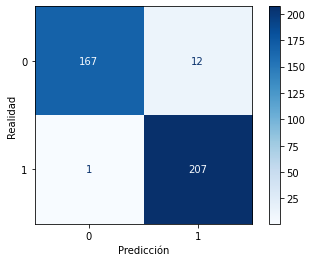

 
3) Cross Val Score (k-fold=5):
time to test process : 1.03 sec
 
==== time to total process! : 1165.43 sec ====


In [34]:
classifier(svc, parameters_svc, X_train_tfidf, y_train, X_test_tfidf, y_test)

### 5.1.2. NuSVM

=> Train
 
Best estimator:  NuSVC(gamma=0.1, nu=0.001, random_state=42)
 
Best mean validation f1 score:  0.9661005048733224
Best std validation f1 score:  0.009744460380679441
 
Best mean validation precision score:  0.9763300507801785
Best std validation precision score:  0.0065216508487966375
 
time to train process : 1317.59 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       179
           1       0.95      1.00      0.97       208

    accuracy                           0.97       387
   macro avg       0.97      0.97      0.97       387
weighted avg       0.97      0.97      0.97       387

 
2) Confussion Matrix
 
[[168  11]
 [  1 207]]


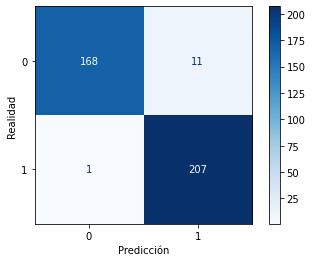

 
3) Cross Val Score (k-fold=5):
time to test process : 0.44 sec
 
==== time to total process! : 1318.03 sec ====


In [35]:
classifier(nusvc, parameters_nusvc, X_train_tfidf, y_train, X_test_tfidf, y_test)

### 5.1.3. Deep Learning

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 300)               1221600   
                                                                 
 dense_91 (Dense)            (None, 100)               30100     
                                                                 
 dense_92 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,251,801
Trainable params: 1,251,801
Non-trainable params: 0
_________________________________________________________________
 
time to train process : 6.89 sec
5/5 - 0s - loss: 0.2336 - precision_29: 0.9224 - f1_score: 0.9461 - 39ms/epoch - 8ms/step
 
Scores:
- Precision score: 0.922374427318573
- F1 score: 0.9461359
 
Curva de Aprendizaje


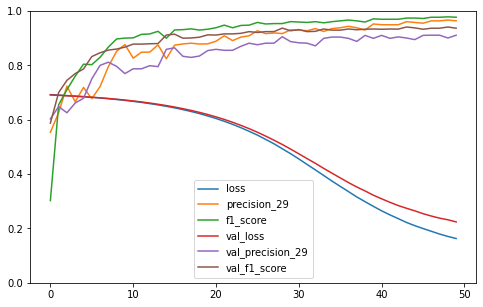

 
13/13 [==============================] - 0s 2ms/step
2) Confussion Matrix
[[162  17]
 [  6 202]]


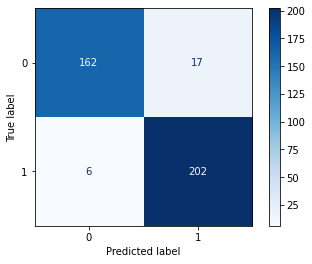

time to test process : 0.49 sec
 
==== time to total process! : 7.39 sec ====


In [ ]:
history = deeplearning(X_train_tfidf, y_train, X_test_tfidf, y_test, 0.025, 50)

## 5.2. Hashing Vectorizer

In [19]:
X_hv = hashingvectorizer(processed)
X_hv.shape

time to embedding process  : 0.07 sec


(1290, 4096)

In [22]:
# Test y Train
X_train_hv, X_test_hv, y_train, y_test = train_test_split(X_hv, y_transformed, test_size=0.3, random_state=42)

### 5.2.1.SVC

=> Train
 
Best estimator:  SVC(C=100, gamma=0.1, random_state=42)
 
Best mean validation f1 score:  0.9620118838956782
Best std validation f1 score:  0.018118370622716828
 
Best mean validation precision score:  0.9732152892462851
Best std validation precision score:  0.012576994732834313
 
time to train process : 264.75 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       179
           1       0.94      0.99      0.96       208

    accuracy                           0.96       387
   macro avg       0.96      0.96      0.96       387
weighted avg       0.96      0.96      0.96       387

 
2) Confussion Matrix
 
[[167  12]
 [  3 205]]


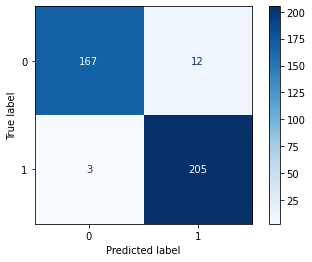

 
time to test process : 1.24 sec
 
==== time to total process! : 265.99 sec ====


In [30]:
classifier(svc, parameters_svc, X_train_hv, y_train, X_test_hv, y_test)

### 5.2.2. NuSVC

=> Train
 
Best estimator:  NuSVC(gamma=0.3727593720314938, nu=0.01, random_state=42)
 
Best mean validation f1 score:  0.9598880179171332
Best std validation f1 score:  0.013863797941173305
 
Best mean validation precision score:  0.9732275314818007
Best std validation precision score:  0.012169234532790712
 
time to train process : 101.78 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       179
           1       0.94      0.99      0.96       208

    accuracy                           0.96       387
   macro avg       0.96      0.96      0.96       387
weighted avg       0.96      0.96      0.96       387

 
2) Confussion Matrix
 
[[166  13]
 [  3 205]]


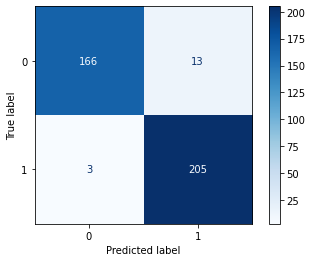

 
time to test process : 1.26 sec
 
==== time to total process! : 103.04 sec ====


In [31]:
classifier(nusvc, parameters_nusvc, X_train_hv, y_train, X_test_hv, y_test)

### 5.2.3. Deep Learning

2022-09-12 16:35:05.698009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-12 16:35:05.699036: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-12 16:35:05.699145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist
2022-09-12 16:35:05.701345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               1229100   
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,259,301
Trainable params: 1,259,301
Non-trainable params: 0
_________________________________________________________________
 
time to train process : 7.42 sec
5/5 - 0s - loss: 0.6608 - precision: 0.8810 - f1_score: 0.8852 - 37ms/epoch - 7ms/step
 
Scores:
- Precision score: 0.8809523582458496
- F1 score: 0.8851674
 
Curva de Aprendizaje


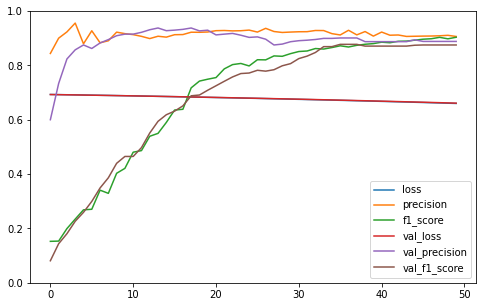

 
13/13 [==============================] - 0s 2ms/step
2) Confussion Matrix
[[154  25]
 [ 23 185]]


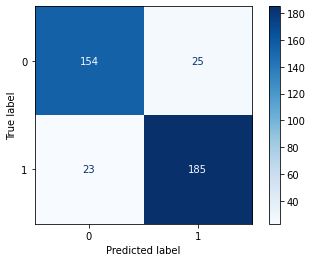

time to test process : 0.52 sec
 
==== time to total process! : 7.94 sec ====


In [32]:
history = deeplearning(X_train_hv, y_train, X_test_hv, y_test, 0.0025, 50)

## 5.3. Small BERT: en uncased L-8 H-768 A-12

In [33]:
X_sbert = bert(text["mensaje"])
X_sbert.shape

time to embedding process  : 88.59 sec


(1290, 768)

In [34]:
# Test y Train
X_train_sbert, X_test_sbert, y_train, y_test = train_test_split(X_sbert, y_transformed, test_size=0.3, random_state=42)

### 5.3.1. SVC

=> Train
 
Best estimator:  SVC(C=100, gamma=0.001, random_state=42)
 
Best mean validation f1 score:  0.9743048882788073
Best std validation f1 score:  0.017230170611389158
 
Best mean validation precision score:  0.9762028682176751
Best std validation precision score:  0.009929775813568607
 
time to train process : 32.42 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       179
           1       0.98      0.98      0.98       208

    accuracy                           0.97       387
   macro avg       0.97      0.97      0.97       387
weighted avg       0.97      0.97      0.97       387

 
2) Confussion Matrix
 
[[174   5]
 [  5 203]]


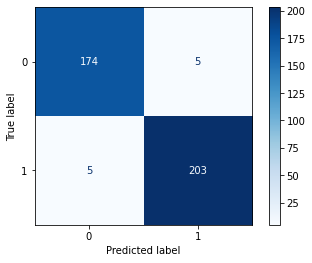

 
time to test process : 0.17 sec
 
==== time to total process! : 32.59 sec ====


In [35]:
classifier(svc, parameters_svc, X_train_sbert, y_train, X_test_sbert, y_test)

### 5.3.2. NuSVC

=> Train
 
Best estimator:  NuSVC(gamma=1e-09, kernel='linear', nu=0.1, random_state=42)
 
Best mean validation f1 score:  0.9783761882499611
Best std validation f1 score:  0.0095381986219308
 
Best mean validation precision score:  0.9793646776255474
Best std validation precision score:  0.007958384032892984
 
time to train process : 15.73 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       179
           1       0.99      0.98      0.98       208

    accuracy                           0.98       387
   macro avg       0.98      0.98      0.98       387
weighted avg       0.98      0.98      0.98       387

 
2) Confussion Matrix
 
[[176   3]
 [  5 203]]


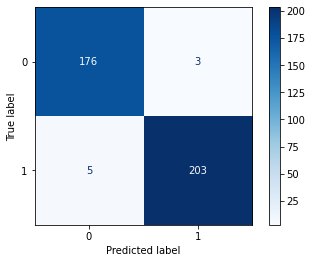

 
time to test process : 0.14 sec
 
==== time to total process! : 15.87 sec ====


In [36]:
classifier(nusvc, parameters_nusvc, X_train_sbert, y_train, X_test_sbert, y_test)

### 5.3.3. Deep Learning

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               230700    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 260,901
Trainable params: 260,901
Non-trainable params: 0
_________________________________________________________________
 
time to train process : 5.53 sec
5/5 - 0s - loss: 0.1731 - precision_1: 0.9381 - f1_score: 0.9426 - 31ms/epoch - 6ms/step
 
Scores:
- Precision score: 0.938095211982727
- F1 score: 0.9425837
 
Curva de Aprendizaje


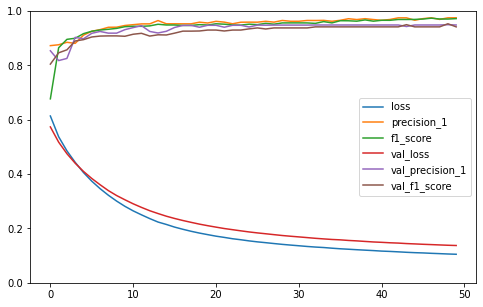

 
13/13 [==============================] - 0s 1ms/step
2) Confussion Matrix
[[166  13]
 [ 11 197]]


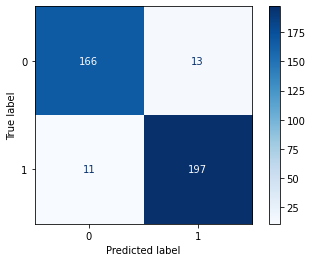

time to test process : 0.44 sec
 
==== time to total process! : 5.97 sec ====


In [37]:
history = deeplearning(X_train_sbert, y_train, X_test_sbert, y_test, 0.0025, 50)

## 5.4. BERT Base: en wwm cased L-24 H-1024 A-16

In [38]:
X_bert = bert(text["mensaje"], 'bert_en_cased_preprocess/3', 'bert_en_wwm_cased_L-24_H-1024_A-16/4')
X_bert.shape

time to embedding process  : 339.77 sec


(1290, 1024)

In [39]:
# Test y Train
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y_transformed, test_size=0.3, random_state=42)

### 5.4.1. SVC

=> Train
 
Best estimator:  SVC(C=100, gamma=0.001, random_state=42)
 
Best mean validation f1 score:  0.9718959315297704
Best std validation f1 score:  0.016791895415111655
 
Best mean validation precision score:  0.9660854238848863
Best std validation precision score:  0.009643426420491503
 
time to train process : 57.86 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       179
           1       0.95      0.96      0.96       208

    accuracy                           0.95       387
   macro avg       0.95      0.95      0.95       387
weighted avg       0.95      0.95      0.95       387

 
2) Confussion Matrix
 
[[169  10]
 [  8 200]]


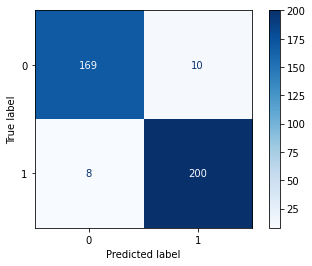

 
time to test process : 0.22 sec
 
==== time to total process! : 58.07 sec ====


In [40]:
classifier(svc, parameters_svc, X_train_bert, y_train, X_test_bert, y_test)

### 5.4.2. NuSVC

=> Train
 
Best estimator:  NuSVC(gamma=0.0001389495494373136, nu=0.1, random_state=42)
 
Best mean validation f1 score:  0.9662625177662771
Best std validation f1 score:  0.026448993619265497
 
Best mean validation precision score:  0.9641993507008987
Best std validation precision score:  0.00878199367310245
 
time to train process : 22.44 sec
 
=> Test
 
1) Report:
 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       179
           1       0.95      0.98      0.96       208

    accuracy                           0.96       387
   macro avg       0.96      0.96      0.96       387
weighted avg       0.96      0.96      0.96       387

 
2) Confussion Matrix
 
[[169  10]
 [  5 203]]


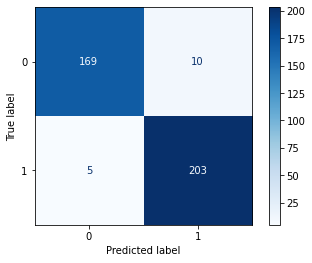

 
time to test process : 0.21 sec
 
==== time to total process! : 22.65 sec ====


In [41]:
classifier(nusvc, parameters_nusvc, X_train_bert, y_train, X_test_bert, y_test)

### 5.4.3. Deep Learning

In [42]:
X_bert = bert(text["mensaje"])
X_bert.shape

time to embedding process  : 67.64 sec


(1290, 768)

In [43]:
# Test y Train
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y_transformed, test_size=0.3, random_state=42)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 300)               230700    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 260,901
Trainable params: 260,901
Non-trainable params: 0
_________________________________________________________________
 
time to train process : 5.56 sec
5/5 - 0s - loss: 0.1671 - precision_2: 0.9390 - f1_score: 0.9501 - 32ms/epoch - 6ms/step
 
Scores:
- Precision score: 0.9389671087265015
- F1 score: 0.9501187
 
Curva de Aprendizaje


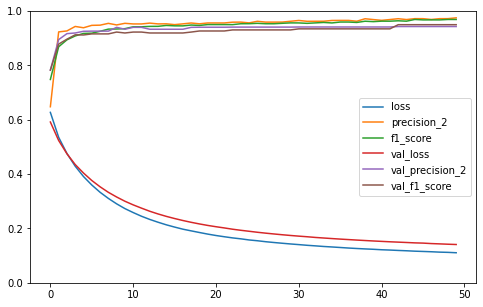

 
13/13 [==============================] - 0s 1ms/step
2) Confussion Matrix
[[166  13]
 [  8 200]]


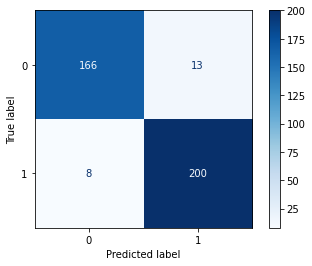

time to test process : 0.45 sec
 
==== time to total process! : 6.0 sec ====


In [44]:
history = deeplearning(X_train_bert, y_train, X_test_bert, y_test, 0.0025, 50)